In [ ]:
!pip install dask
!pip install dask[dataframe]
!pip install soundfile
!pip install librosa numpy pandas matplotlib seaborn noisereduce


  Obtaining dependency information for soundfile from https://files.pythonhosted.org/packages/50/ff/26a4ee48d0b66625a4e4028a055b9f25bc9d7c7b2d17d21a45137621a50d/soundfile-0.12.1-py2.py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------- -------------------------------- 0.2/1.0 MB 5.9 MB/s eta 0:00:01
   ----------------------- ---------------- 0.6/1.0 MB 7.5 MB/s eta 0:00:01
   ------------------------------------- -- 1.0/1.0 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 7.1 MB/s eta 0:00:00
  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/8c/8a/2d231b35456506b7c98b3ab9bbf07917b205fed8615d2e59e976ab497fff/librosa-0.10.2.post1-py3-none-any.whl.metadata
  Obtaining dependency information for noisereduce from https://files.pythonhosted.org/packages/f0/5e/d3c72f395b71d1bf513cfa5b990dd5421aa74de3670eaab53e51ae6ce401/noisereduce-3.0.2-py3-none-any.whl.metadata


In [ ]:
import os
import dask.dataframe as dd
import soundfile as sf
import numpy as np
import pandas as pd
from dask import delayed
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import noisereduce as nr
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

%matplotlib inline


getting Flac Files

In [ ]:
def get_all_file_paths(root_dir):
    file_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths


Extract Features

In [ ]:
def get_flac_file_paths(root_dir):
    flac_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.flac'):
                flac_files.append(os.path.join(dirpath, filename))
    return flac_files


In [ ]:
def extract_features(file_path):
    data, samplerate = sf.read(file_path)
    mean_signal = np.mean(data)
    return pd.DataFrame({'file_path': [file_path], 'mean_signal': [mean_signal]})


In [ ]:
def reduce_noise(y, sr):
    return nr.reduce_noise(y=y, sr=sr)


Loading Audio Data

In [ ]:
dev_clean_dir = os.path.expanduser('C:/Users/Gaman/Downloads/dataset_speech (1)/dataset_speech/dev-clean')
file_paths = get_flac_file_paths(dev_clean_dir)

delayed_results = [delayed(extract_features)(file_path) for file_path in file_paths]
dask_df = dd.from_delayed(delayed_results)
df = dask_df.compute()
print(df.head())


                                           file_path  mean_signal
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...    -0.000009
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...    -0.000029
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...    -0.000011
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...     0.000005
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...     0.000007


Aggregate Audio Data

In [ ]:
def aggregate_audio_data(directory):
    mfccs_list = []
    chroma_list = []
    zcr_list = []
    durations = []
    centroid_list = []
    bandwidth_list = []

    for folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".flac"):
                file_path = os.path.join(folder, file)
                y, sr = librosa.load(file_path)

                # Reduce noise
                y = reduce_noise(y, sr)

                # Extract MFCCs
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfccs_mean = np.mean(mfccs, axis=1)
                mfccs_list.append(mfccs_mean)

                # Extract chroma features
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                chroma_mean = np.mean(chroma, axis=1)
                chroma_list.append(chroma_mean)

                # Extract zero-crossing rate
                zcr = librosa.feature.zero_crossing_rate(y)
                zcr_mean = np.mean(zcr)
                zcr_list.append(zcr_mean)

                # Extract spectral centroid
                centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
                centroid_mean = np.mean(centroid)
                centroid_list.append(centroid_mean)

                # Extract spectral bandwidth
                bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                bandwidth_mean = np.mean(bandwidth)
                bandwidth_list.append(bandwidth_mean)

                # Extract duration
                duration = librosa.get_duration(y=y, sr=sr)
                durations.append(duration)

    # Converting to DataFrame
    data = pd.DataFrame(mfccs_list, columns=[f'MFCC{i+1}' for i in range(13)])
    data[['Chroma' + str(i+1) for i in range(12)]] = pd.DataFrame(chroma_list)
    data['Zero Crossing Rate'] = zcr_list
    data['Duration'] = durations
    data['Spectral Centroid'] = centroid_list
    data['Spectral Bandwidth'] = bandwidth_list

    return data


Visualization

In [ ]:
def visualize_data(data):
    print("Summary statistics of MFCCs:")
    print(data.iloc[:, :13].describe())
    print()

    plt.figure(figsize=(10, 8))
    sns.heatmap(data.iloc[:, :13].corr(), annot=True,fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of MFCCs')
    plt.show()

    plt.figure(figsize=(12, 6))
    data.iloc[:, :13].boxplot()
    plt.title('Boxplots of MFCCs')
    plt.xlabel('MFCC Coefficients')
    plt.ylabel('Values')
    plt.show()

    plt.figure(figsize=(12, 6))
    data.iloc[:, 13:25].boxplot()
    plt.title('Boxplots of Chroma Features')
    plt.xlabel('Chroma Features')
    plt.ylabel('Values')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(data['Zero Crossing Rate'], bins=20,color='skyblue', edgecolor='black')
    plt.title('Histogram of Zero Crossing Rate')
    plt.xlabel('Zero Crossing Rate')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(data['Duration'], bins=20, color='skyblue',edgecolor='black')
    plt.title('Histogram of Audio Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(data['Spectral Centroid'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of Spectral Centroid')
    plt.xlabel('Spectral Centroid')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(data['Spectral Bandwidth'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of Spectral Bandwidth')
    plt.xlabel('Spectral Bandwidth')
    plt.ylabel('Frequency')
    plt.show()


Total files found: 2833
                                           file_path  mean_signal
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...    -0.000009
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...    -0.000029
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...    -0.000011
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...     0.000005
0  C:/Users/Gaman/Downloads/dataset_speech (1)/da...     0.000007
Summary statistics of MFCCs:
             MFCC1        MFCC2        MFCC3        MFCC4        MFCC5  \
count  2703.000000  2703.000000  2703.000000  2703.000000  2703.000000   
mean   -533.003418    71.435455    -2.562556    28.815125    -2.954286   
std      47.250992    15.054893    14.387557    11.355713     8.850476   
min    -788.391602    23.003830   -68.929581    -9.636219   -31.047735   
25%    -551.698914    60.877140    -9.888931    21.225077    -9.229470   
50%    -528.404846    71.344086    -1.187431    28.892656    -2.997216   
75%    -507.122879    81.652454  

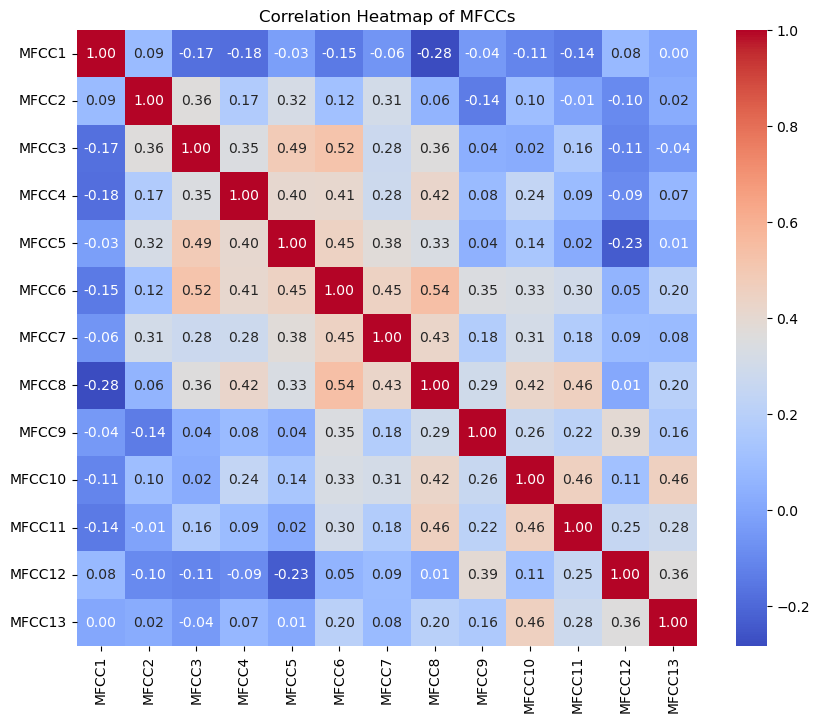

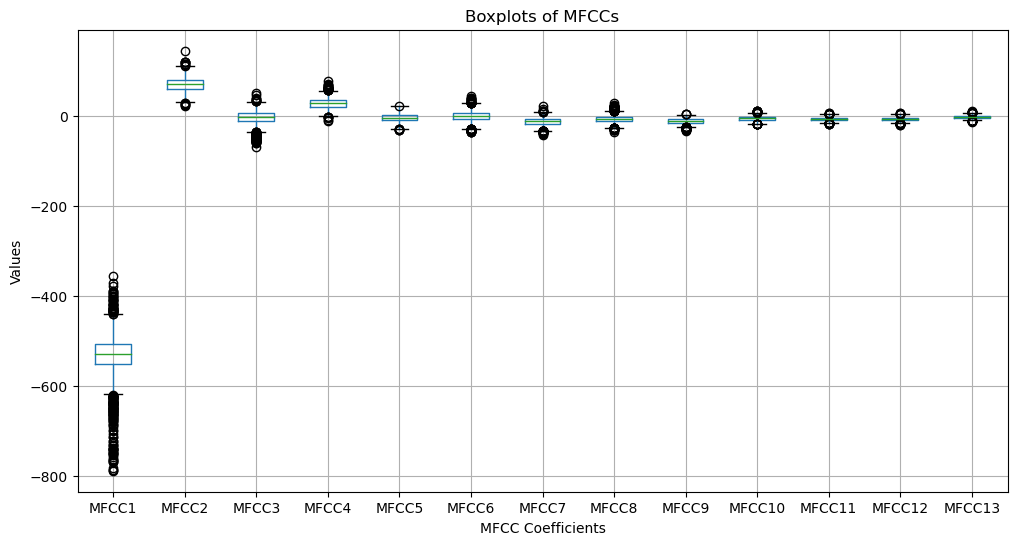

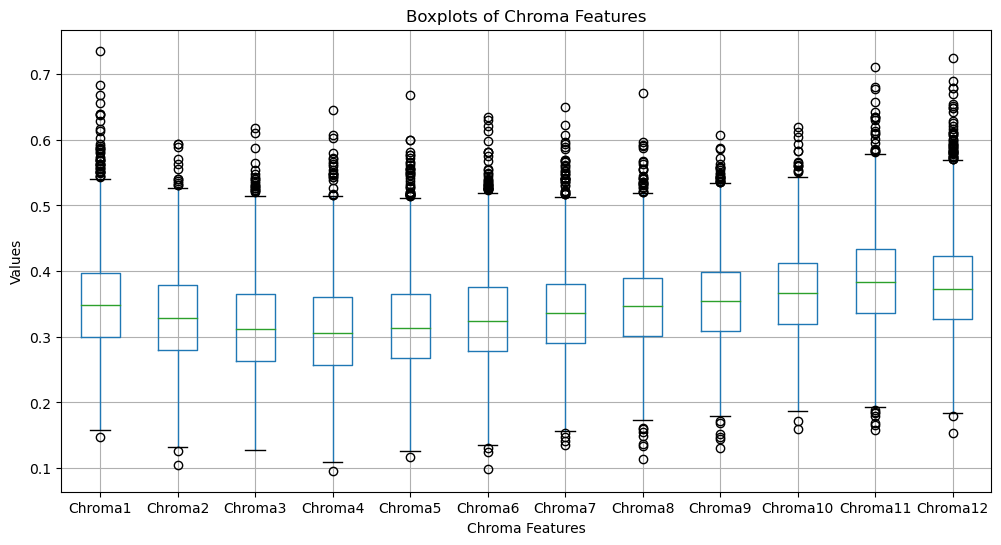

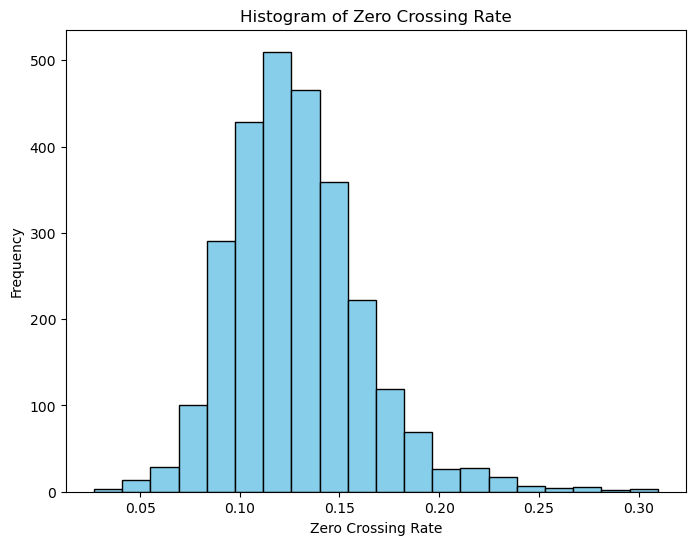

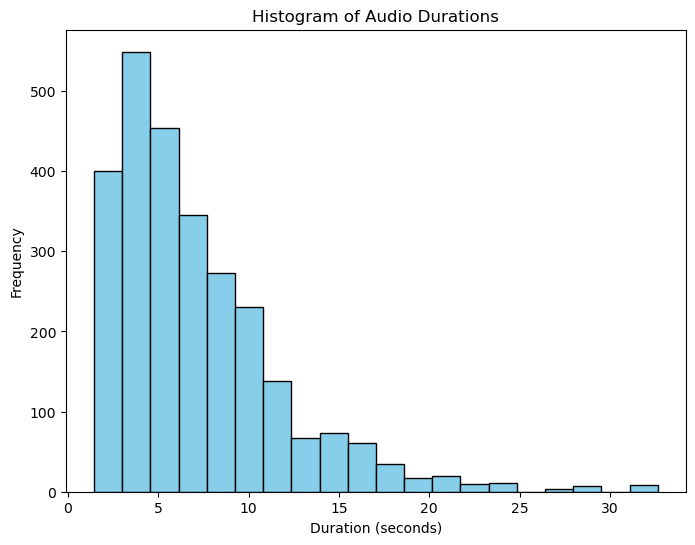

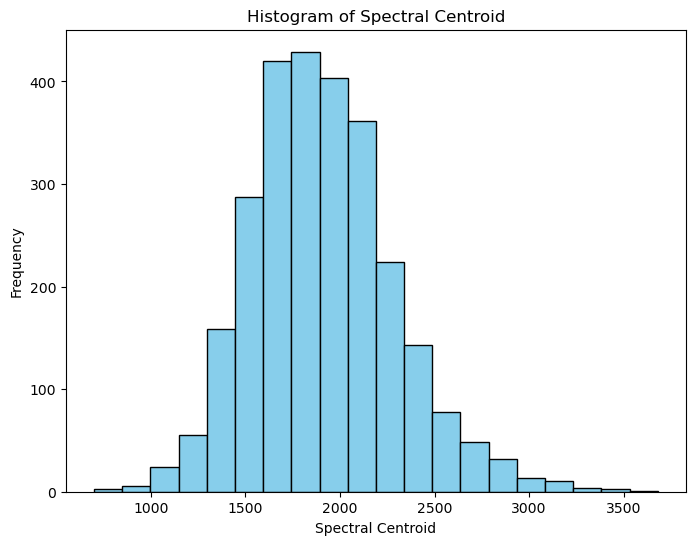

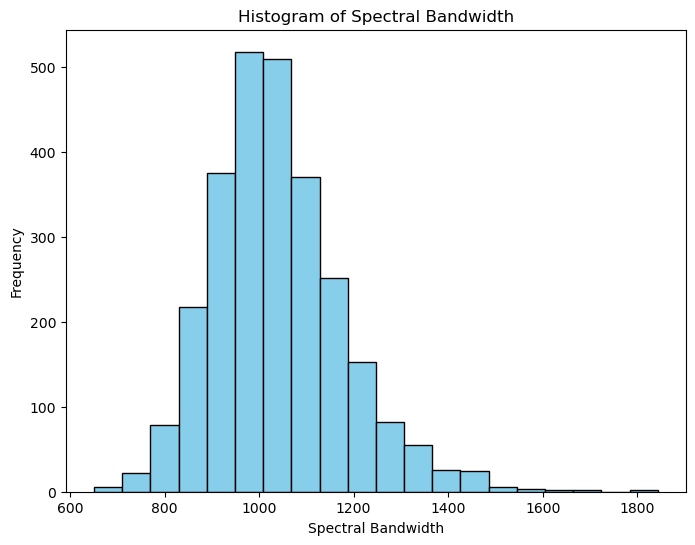

In [ ]:
if __name__ == "__main__":
    #dev_clean_dir = os.path.expanduser('dev-clean/')

    # List of all file paths
    all_file_paths = get_all_file_paths(dev_clean_dir)
    print(f"Total files found: {len(all_file_paths)}")

    # List of FLAC file paths
    file_paths = get_flac_file_paths(dev_clean_dir)

    # Using Dask delayed to handle the out-of-core computation
    delayed_results = [delayed(extract_features)(file_path) for file_path in file_paths]
    dask_df = dd.from_delayed(delayed_results)

    # Performing the computation and load into a Dask dataframe
    df = dask_df.compute()
    print(df.head())

    # Aggregating audio data
    audio_data = aggregate_audio_data(dev_clean_dir)

    # Visualizing the aggregated data
    visualize_data(audio_data)


Model Building

In [ ]:
features = audio_data.values
labels = np.zeros((len(features),))  # Dummy labels, replace with actual if available

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=12)


In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


Defining Model Architecture

In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


training The model

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
76/76 [==============================] - 1s 5ms/step - loss: 0.0490 - accuracy: 0.9979 - val_loss: 2.1748e-29 - val_accuracy: 1.0000
Epoch 2/5
76/76 [==============================] - 0s 4ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 3.4875e-37 - val_accuracy: 1.0000
Epoch 3/5
76/76 [==============================] - 0s 4ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 2.8940e-37 - val_accuracy: 1.0000
Epoch 4/5
76/76 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 2.7587e-37 - val_accuracy: 1.0000
Epoch 5/5
76/76 [==============================] - 0s 4ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 2.6563e-37 - val_accuracy: 1.0000


Model Accuracy

9/9 [==============================] - 0s 3ms/step - loss: 2.6563e-37 - accuracy: 1.0000
Test Accuracy: 100.00%


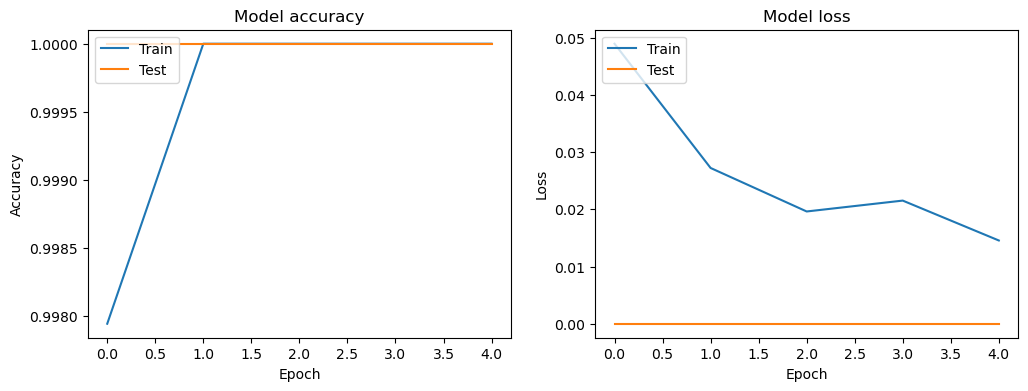

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
